In [2]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import re
import squarify

from functions import run_proportional_scaling, run_linear_programming, save_data_to_time_series
from helpers import fetch_area_data, get_variables
from tree import build_tree, fetch_branch, fetch_values_given_key, get_subindustries_data, \
    get_objective, get_constraints, write_into
from config import settings

In [3]:
print('51163 Rockbridge County, Virginia')
df, url = fetch_area_data('2021',4,'51163')

51163 Rockbridge County, Virginia


In [4]:
# https://www.bls.gov/cew/classifications/aggregation/agg-level-titles.htm
total_establishments = int(df[df['agglvl_code']==70][settings.establishments])
print(f"Total establishments in the county: {total_establishments}") 
aggregations = range(74,78+1)
for aggregation in aggregations:
    print(f"The sum of establishment counts at level {aggregation}: {np.sum(df[df['agglvl_code']==aggregation][settings.establishments])}")

Total establishments in the county: 542
The sum of establishment counts at level 74: 542
The sum of establishment counts at level 75: 542
The sum of establishment counts at level 76: 542
The sum of establishment counts at level 77: 542
The sum of establishment counts at level 78: 542


In [5]:
# cast data into a tree structure with nested mappings
# county = {'ind': 10, 'est': 533, 'emp': 5937, children': [{}, {}, ...]}
county = build_tree(df, '10', 71)

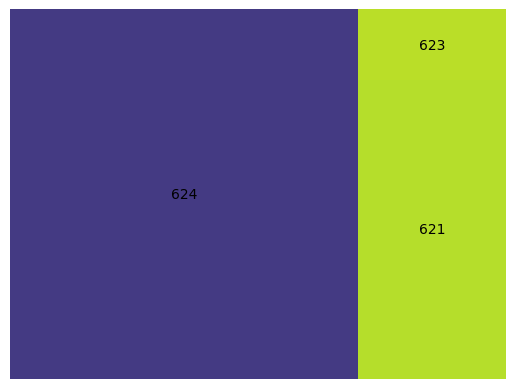

In [6]:
# Return industry details
industry = fetch_branch(county, 'ind', '62')
sub_industries = [sub_industry['ind'] for sub_industry in industry['children']]
est = [sub_industry['est'] for sub_industry in industry['children']]

sub_industries_sorted = [ind for _, ind in sorted(zip(est, sub_industries), reverse=True)]
est_sorted = sorted(est, reverse=True)
squarify.plot(sizes=est_sorted, label=sub_industries_sorted)
plt.axis('off')
plt.show()

In [7]:
# Proportional scaling example
industry = fetch_branch(county, 'ind', '10')
print('*** overall number of establishments ***')
print(industry['est'])
print('*** overall employment ***')
print(industry['emp'])
print('*** sub industries ***')
print([sub_industry['ind'] for sub_industry in industry['children']])
print('*** number of establishments in the sub industries ***')
print([sub_industry['est'] for sub_industry in industry['children']])
print('*** employment in the sub industries ***')
print([sub_industry['emp'] for sub_industry in industry['children']])
print('*** employment approximation proportional scaling ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
employment = np.array([sub_industry['emp'] for sub_industry in industry['children']],dtype = object)
employment_ps = employment.copy()
undisclosed_est = np.sum(establishments[np.where(employment==0)])
undisclosed_emp = industry['emp'] - np.sum(employment)
employment_ps[np.where(employment==0)] = establishments[np.where(employment==0)]/undisclosed_est*undisclosed_emp
print(employment_ps)
print('*** wages in the sub industries ***')
print([sub_industry['wages'] for sub_industry in industry['children']])
print('*** wages approximation proportional scaling ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
wages = np.array([sub_industry['wages'] for sub_industry in industry['children']],dtype = object)
wages_ps = wages.copy()
undisclosed_est = np.sum(establishments[np.where(wages==0)])
undisclosed_wages = industry['wages'] - np.sum(wages)
wages_ps[np.where(wages==0)] = establishments[np.where(wages==0)]/undisclosed_est*undisclosed_wages
print(wages_ps)



*** overall number of establishments ***
512
*** overall employment ***
4752
*** sub industries ***
['11', '21', '22', '23', '31_33', '42', '44_45', '48_49', '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '99']
*** number of establishments in the sub industries ***
[17, 1, 2, 74, 25, 13, 62, 17, 9, 18, 9, 33, 2, 26, 5, 87, 13, 46, 41, 12]
*** employment in the sub industries ***
[0, 0, 0, 369, 897, 0, 1196, 77, 29, 106, 18, 0, 0, 0, 69, 507, 112, 584, 148, 17]
*** employment approximation proportional scaling ***
[112.67021276595746 6.627659574468085 13.25531914893617 369 897
 86.15957446808511 1196 77 29 106 18 218.7127659574468 13.25531914893617
 172.31914893617022 69 507 112 584 148 17]
*** wages in the sub industries ***
[0, 0, 0, 5804030, 10083092, 0, 9508668, 1079078, 400983, 1485148, 279793, 0, 0, 0, 683429, 5824644, 1057960, 3722327, 1286572, 142041]
*** wages approximation proportional scaling ***
[1471543.510638298 86561.3829787234 173122.7659574468 5804030

In [8]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = employment,
        name = 'employment'
    )
)
fig.add_trace(
    go.Bar(
        y = employment_ps,
        name = 'employment ps'
    )
)
fig.update_layout(
    title='Employment and employment approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [9]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = wages,
        name = 'wages'
    )
)
fig.add_trace(
    go.Bar(
        y = wages_ps,
        name = 'wages ps'
    )
)
fig.update_layout(
    title='Wages and wages approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [10]:
# loop through the entire tree
for ind in fetch_values_given_key(county, 'ind', []):
    industry = fetch_branch(county, 'ind', ind)
    data = get_subindustries_data(industry)
    county = run_proportional_scaling(county, industry, data)

In [11]:
# Define objective function
objective_function = get_objective(county, 'emp', str(county['emp']))

# Define constraints
constraints = get_constraints(county, 'emp', [])

# Define variables
variables = []
for constraint in constraints:
    variables+=re.findall(r"epe_[^ ]* ", constraint)
for variable in list(np.unique(variables)):
    exec(f"{variable} = cp.Variable()")

# Define the objective function
exec(f"objective = cp.Minimize(cp.abs({objective_function}))")

# Define numerical constraints
numerical_constraints = []
for i,constraint in enumerate(constraints):
    if i > 0:
        numerical_constraints.append(eval(f"{constraint.replace('=','==')}"))
# Adding non-negativity constraints for the variables
for variable in list(np.unique(variables)):
    numerical_constraints.append(eval(f"{variable}>= 0"))

# Form and solve the problem
problem = cp.Problem(objective, numerical_constraints)
problem.solve()

1.3322676295501878e-12

In [12]:
for variable in variables:
    ind = variable[variable.find('_')+1:-1]
    branch = fetch_branch(county, 'ind', ind)
    if branch['emp'] == 0:
        write_into(
            county, 'ind', branch['ind'],
            {'emp_lp': branch['est'] * eval(f"float({variable}.value)")}
        )


In [13]:
industry = fetch_branch(county, 'ind', '31_33')
print(industry['est'])
print(industry['emp'])
if industry.get('emp_ps') is not None:
    print(f"emp_ps {industry['emp_ps']}")
if industry.get('emp_lp') is not None:
    print(f"emp_lp {industry['emp_lp']}")
for child in industry['children']:
    print(f"*** ind {child['ind']} *** ")
    print(child['est'])
    print(child['emp'])
    if child.get('emp_ps') is not None:
        print(f"emp_ps {child['emp_ps']}")
    if child.get('emp_lp') is not None:
        print(f"emp_lp {child['emp_lp']}")

25
897
*** ind 311 *** 
2
0
emp_ps 108.66666666666667
emp_lp 99.72753209649419
*** ind 312 *** 
3
28
*** ind 314 *** 
1
0
emp_ps 54.333333333333336
emp_lp 46.2454703866727
*** ind 321 *** 
6
168
*** ind 323 *** 
2
0
emp_ps 108.66666666666667
emp_lp 123.17152621768442
*** ind 326 *** 
1
0
emp_ps 54.333333333333336
emp_lp 46.2454703866727
*** ind 332 *** 
4
49
*** ind 333 *** 
2
0
emp_ps 108.66666666666667
emp_lp 144.39152804247414
*** ind 335 *** 
1
0
emp_ps 54.333333333333336
emp_lp 46.2454703866727
*** ind 337 *** 
2
0
emp_ps 108.66666666666667
emp_lp 99.7275320966565
*** ind 339 *** 
1
0
emp_ps 54.333333333333336
emp_lp 46.2454703866727


In [14]:
# Fetch all industry codes in a period
county_code = '51163'
years = list(range(2014,2021+1))
industry_codes = []
for year in years:
    df, url = fetch_area_data(year,4,county_code)
    county = build_tree(df, '10', 71)
    industry_codes+=fetch_values_given_key(county, 'ind', [])
time_series = pd.DataFrame([], columns=np.unique(industry_codes))

In [15]:
# Run LP on all industries and all the years and save to time_series
for year in years:
    df, url = fetch_area_data(year,4,county_code)
    county = build_tree(df, '10', 71)
    county = run_linear_programming(county, 'emp')
    for ind in industry_codes:
        industry = fetch_branch(county, 'ind', ind)
        if industry is not None:
            if industry.get('emp_lp') is not None:
                time_series.at[year, ind] = industry['emp_lp']
            else:
                time_series.at[year, ind] = industry['emp']

In [16]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = years,
        y = time_series['5221']
    )
)
fig.update_layout(
    title='Employment approximation with LP',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [17]:
time_series.pct_change().std().sort_values(ascending=False)[0:20]

238351    3.076218e+13
23835     3.029560e+13
31192     3.966628e+00
311920    3.966628e+00
3119      3.966628e+00
541618    3.039740e+00
53111     3.032692e+00
531110    3.032692e+00
5311      3.032692e+00
5411      2.997322e+00
54111     2.997322e+00
541110    2.997322e+00
61162     2.661121e+00
611620    2.661121e+00
53131     2.564458e+00
5313      2.555478e+00
236115    2.492447e+00
238311    2.364017e+00
23831     2.364017e+00
541519    2.293352e+00
dtype: float64

In [21]:
time_series.to_csv('Rockbridge_employment.csv')

In [19]:
# Fetch all industry codes in a period
county_code = '13121'
years = list(range(2014,2021+1))
industry_codes = []
for year in years:
    df, url = fetch_area_data(year,4,county_code)
    county = build_tree(df, '10', 71)
    industry_codes+=fetch_values_given_key(county, 'ind', [])
employment_series = pd.DataFrame([], columns=np.unique(industry_codes))
wages_series = pd.DataFrame([], columns=np.unique(industry_codes))


In [22]:
# Run LP on all industries and all the years and save to time_series
for year in years:
    df, url = fetch_area_data(year,4,county_code)
    county = build_tree(df, '10', 71)
    county = run_linear_programming(county, 'emp')
    county = run_linear_programming(county, 'wages')
    employment_series = save_data_to_time_series(
        employment_series, county, industry_codes, 'emp', year
    )    
    wages_series = save_data_to_time_series(
        wages_series, county, industry_codes, 'wages', year
    )

/Users/nikolamirkov/Upwork/20221229 QCEW/QCEW-Project/env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/Users/nikolamirkov/Upwork/20221229 QCEW/QCEW-Project/env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/Users/nikolamirkov/Upwork/20221229 QCEW/QCEW-Project/env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/Users/nikolamirkov/Upwork/20221229 QCEW/QCEW-Project/env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or

In [23]:
employment_series

,10,11,111,1112,11121,111219,1113,11133,111335,111336,...,813990,814,8141,81411,814110,99,999,9999,99999,999999
2014,693762,221,78,45.73706,45.73706,45.73706,NaN,NaN,NaN,NaN,...,485,1234,1234,1234,1234,3513,3513,3513,3513,3513
2015,712929,192,35,3.345563,3.345563,3.345563,NaN,NaN,NaN,NaN,...,480,1160,1160,1160,1160,2543,2543,2543,2543,2543
2016,746100,167,39,4.5,4.5,4.5,NaN,NaN,NaN,NaN,...,475,1141,1141,1141,1141,2828,2828,2828,2828,2828
2017,770613,146,28,4.287135,4.287135,4.287135,NaN,NaN,NaN,NaN,...,530,1067,1067,1067,1067,1698,1698,1698,1698,1698
2018,792765,155,33,5.150109,5.150109,5.150109,1.97346,1.97346,NaN,NaN,...,556,968,968,968,968,1543,1543,1543,1543,1543
2019,817859,155,46,2.798905,2.798905,2.798905,15,15,5.0,5.0,...,510,899,899,899,899,2204,2204,2204,2204,2204
2020,758087,161,38,6.338854,6.338854,6.338854,6.661146,6.661146,2.220382,2.220382,...,523,761,761,761,761,1819,1819,1819,1819,1819
2021,810204,188,71,10.589461,10.589461,10.589461,4.410539,4.410539,2.205269,NaN,...,559,730,730,730,730,3285,3285,3285,3285,3285


In [24]:
employment_series.pct_change().std().sort_values(ascending=False)[0:20]

31213     22.389436
312130    22.389436
334413    18.836008
334111    16.942860
311511    14.763423
525920    14.458820
52592     14.458820
3351      11.340634
33512     11.340634
335122    11.227492
339910     9.059747
33991      9.059747
312140     8.329747
31214      8.329747
334112     8.108354
31151      7.559260
335999     7.106543
33599      7.106543
33441      6.444975
3344       6.444975
dtype: float64

In [25]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = years,
        y = employment_series['713950'],
        name = 'disclosed'
    )
)
fig.add_trace(
    go.Scatter(
        x = years[-2:],
        y = employment_series['713950'].iloc[-2:],
        name = 'undisclosed'

    )
)
fig.update_layout(
    title='Employment in Bowling Centers (713950), Fulton Georgia',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [26]:
employment_series.columns = employment_series.columns.str.replace('_', '-')
employment_series.to_csv('Fulton_employment.csv')

In [27]:
wages_series.pct_change().std().sort_values(ascending=False)[0:20]

3351      44.917874
33512     44.917874
335122    44.772919
525920    41.135773
52592     41.135773
491       36.881520
4911      36.881520
49111     36.881520
491110    36.881520
33991     29.386012
339910    29.386012
311511    28.087656
334413    26.472047
31213     24.682039
312130    24.682039
238291    22.745185
487       21.325244
4879      21.248653
48799     21.248653
487990    21.248653
dtype: float64

In [28]:
wages_series.columns = wages_series.columns.str.replace('_', '-')
wages_series.to_csv('Fulton_wages.csv')